In [1]:
#required Libraries
import sys,glob,csv,os;
import pandas as pd;
import time,datetime;
import matplotlib.pyplot as plt;
import json
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks
dict_months = {"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07"
              ,"Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"};

csv.field_size_limit(sys.maxsize)
journo_list = ["Maria_Ressa", "Camille_Diola", "Inday_Espina-Varona", "Chiara_Zambrano", "Karen_Davila", "Pia_Ranada"]

#Set directory
os.chdir("/nfs/sloanlab003/projects/rappler_proj/rappler/sharktank-export")
!pwd

/nfs/sloanlab003/projects/rappler_proj/rappler/sharktank-export


In [2]:
#Functions for obtaining date and journo names in comment data
def formatDate(date_str):
    date_str_split = date_str.split("-")
    try:
        return date_str_split[1] + "-" + dict_months[date_str_split[0]] + "-" + date_str_split[2];
    except:
        return;
def find_substring(needle, haystack):
    search_start = 0
    while (search_start < len(haystack)):
        index = haystack.find(needle, search_start)
        if index == -1:
            return False
        is_prefix_whitespace = (index == 0 or haystack[index-1] in string.whitespace)
        search_start = index + len(needle)
        is_suffix_whitespace = (search_start == len(haystack) or haystack[search_start] in string.whitespace)
        if (is_prefix_whitespace and is_suffix_whitespace):
            return True
    return False

### Functions for grabbing comments

In [3]:
def grab_dates(journalist, msg_type, suppress_print = True):
    '''
    Test function to look at how the Rappler hate speech code for getting journalist comments and posts actually grabs dates.
    journalist(str): The journalist in question: Ressa, Robredo, Delima
    msg_type(str): comment, post, m_post.
    suppress_print (bool): If true, only prints the final summary of messages looked at and the dates. If false, prints the messages as well
    '''
    dict_dates = {};
    count = 0
    long_enough = 0
    processed = 0
    for infile in glob.glob(f"processed_stats/{msg_type}/{journalist}_posts/*"):
        #print(infile)
        with open(infile,"r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                count+=1
                if(len(row)<10):
                    continue;
                long_enough +=1
                try:
                    #print("XXX",row[1]+row[2])
                    date_split = row[-1].split(" ");
                    year = int(date_split[3]);
                    created_date = date_split[1] + "-" + date_split[2] + "-" + date_split[3];
    #                created_date1 = date_split[2] + "-" + dict_months[date_split[1]] + "-" + date_split[3];
    #                unixtime = time.mktime(datetime.datetime.strptime(created_date1, "%d-%m-%Y").timetuple())
    #                if(unixtime>1588291200 and unixtime<1593561600):
    #                    out.write((",").join(row) + "\n");
                    #print(created_date)
                    if not suppress_print:
                        print("\nFile: ", infile, '\n')
                        #print("Comment", row)
                        print("Last Row: ", row[-1])
                        print("7th Row (Check on the other code block from the notebook): ", row[7])
                    dict_dates[created_date] = dict_dates.get(created_date,0) + 1;
                    processed +=1
                except:
                    continue;

    #            count += 1;
    #            if(count>10):
    #                break;
    #    break;
    print("Num Messages Seen: ", count, "\nNum Messages Longer than 10 elements:", long_enough, "\nNum Messages with valid \"dates\": ", processed)
    print(json.dumps(dict_dates, indent=4))
    
#So the old code isn't gonna work. Let's try another way.
def grab_dates_new(journalist, msg_type, line=-1, suppress_print = 0, delim = ',', min_length = 0, local = False):
    '''
    Test function to modify the original Rappler code so that it actually gets dates.
    journalist(str): The journalist in question: Ressa, Robredo, Delima
    msg_type(str): comment, post, m_post. I'm ignoring m_post for now
    line(int): # Row that we take the date from. Default is -1, the old number
    suppress_print (int: 0,1,2): If 0, only prints final statement. If 1, prints dates. If 2, prints dates and all messages
    local (bool): if local is true, then it is set to local directory for use with local files
    '''
    dict_dates = {};
    count = 0
    long_enough = 0
    processed = 0
    #i=1
    source_path = f"processed_stats/{msg_type}/{journalist}_posts/*"
    if local:
        source_path = f"/home/jabill/journo_hate_comments/{journalist}_posts*"
    for infile in glob.glob(source_path):
        #print(infile)
        with open(infile,"r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter=delim)
            for row in spamreader:
                #if i < 5:
                #    print(row)
                #i+=1
                count +=1
                if(len(row)<min_length):
                    continue;
                long_enough +=1
                try:
                    #print("XXX",row[1]+row[2])
                    date_split = row[line].split(" ");
                    year = int(date_split[3]);
                    created_date = date_split[1] + "-" + date_split[2] + "-" + date_split[3];
    #                created_date1 = date_split[2] + "-" + dict_months[date_split[1]] + "-" + date_split[3];
    #                unixtime = time.mktime(datetime.datetime.strptime(created_date1, "%d-%m-%Y").timetuple())
    #                if(unixtime>1588291200 and unixtime<1593561600):
    #                    out.write((",").join(row) + "\n");
                    #print(created_date)
                    if suppress_print == 2:
                        print("\nFile: ", infile, '\n')
                        #print("Comment", row)
                        print("Row of Split, Line ", line, ": ", row[line])
                    dict_dates[created_date] = dict_dates.get(created_date,0) + 1;
                    processed +=1
                except:
                    continue;

    #            count += 1;
    #            if(count>10):
    #                break;
    #    break;
    if suppress_print > 0:
        print(json.dumps(dict_dates, indent=4))
    print("Num Messages Seen: ", count, f"\nNum Messages Longer than {min_length} elements:", long_enough, "\nNum Messages with valid \"dates\": ", processed)

    return dict_dates
    
def cycle_thru(journalist, msg_type, num, start, min_length = 0, delim = ','):
    '''Shows the first (num) messages in a file. Default has no length constraint (i.e. set to zero)
        Start is an integer representing which csv file is taken in
        (EX: if start=0, then we take the file out-{0}-{1}000000. If start=10, then it's {10}000000-{11}000000)
        Delim is the delimeter used when reading the file. Default is comma (as this is what the initial code did)
    '''
    csv_range = str(start * 1000000) + "-" + str((start+1) *1000000) 
    with open(f"processed_stats/{msg_type}/{journalist}_posts/out-{csv_range}.csv") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=delim)
        i=0
        count = 1
        for row in spamreader:
            print("File num ", count)
            count+=1
            if(len(row)< min_length):
                continue;
            print(len(row))
            #print(row[-1])
            for id,x in enumerate(row):
                print(id, x)
            i+=1
            if i==num:
                break
                
                
def grab_hate_comments(journalist = "", suppress_print = 0, min_length = 0, local = False):
    '''
    Gets count of hate comments directed at selected journalists by date.
    journalist (str): Journalist of interest. Default selects all hate comments
    suppress_print (int): If 0, no print statements are run. If 1, a summary statement is printed
                          If 2, all print statements are run.
    min_length (int): Minimum length of accepted comments. Shorter comments are not counted    
    '''
    dict_dates = {}
    count = 0
    long_enough = 0
    processed = 0
    for infile in glob.glob("processed_stats/comments/hate/*"):
        if suppress_print==2:
            print(infile)
        with open(infile, "r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter='\t')
            for row in spamreader:
                count +=1
                if(len(row)<min_length):
                    continue
                long_enough +=1
                message = row[5]
                #check for espina-varona and espina varona
                extra = journalist
                if journalist == "espina-varona" :
                    extra = "espina varona"
                if journalist in message or extra in message:
                    try: #Date is at index 4
                        date_split = row[4].split(" ")
                        year = int(date_split[3])
                        created_date = date_split[1] + "-" + date_split[2] + "-" + date_split[3];
                        if suppress_print == 2:
                            print("\nFile: ", infile, '\n')
                            #print("Comment", row)
                            print("Row of Split, Line ", line, ": ", row[line])
                        dict_dates[created_date] = dict_dates.get(created_date,0)+1
                        processed +=1
                    except:
                        continue;

    #            count += 1;
    #            if(count>10):
    #                break;
    #    break;
    if suppress_print > 0:
        print(json.dumps(dict_dates, indent=4))
    print("Num Messages Seen: ", count, f"\nNum Messages Longer than {min_length} elements:", long_enough, "\nNum Messages with valid \"dates\": ", processed)
    return dict_dates


In [4]:
#Find the number of comments per day mentioning a journalist:
def get_total_comments(journalist = "", suppress_print = 0, min_length = 0, local = False):
    '''
    Gets count of comments (hateful or not) directed at selected journalists by date.
    journalist (str): Journalist of interest. Default selects all comments
    suppress_print (int): If 0, no print statements are run. If 1, a summary statement is printed
                          If 2, all print statements are run.
    min_length (int): Minimum length of accepted comments. Shorter comments are not counted    
    '''
    line = -1
    dict_dates = {};
    count = 0
    long_enough = 0
    processed = 0
    #i=1
    source_path = f"/home/jabill/journo_hate_comments/{journalist}_posts/*"
    for infile in glob.glob(source_path):
        if suppress_print == 2:
            print(infile)
        with open(infile,"r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter='\t')
            for row in spamreader:
                if suppress_print == 2:
                    print(row)
                count +=1
                if(len(row)<min_length):
                    continue
                long_enough +=1
                message = row[5]
                #check for espina-varona and espina varona
                #extra = journalist
                #if journalist == "espina-varona" :
                #    extra = "espina varona"
                #if journalist in message or extra in message:
                try: #Date is at index 4
                    date_split = row[4].split(" ")
                    year = int(date_split[3])
                    created_date = date_split[1] + "-" + date_split[2] + "-" + date_split[3];
                    if suppress_print == 2:
                        print("\nFile: ", infile, '\n')
                        #print("Comment", row)
                        print("Row of Split, Line ", line, ": ", row[line])
                    dict_dates[created_date] = dict_dates.get(created_date,0)+1
                    processed +=1
                except:
                    continue;
    if suppress_print > 0:
        print(json.dumps(dict_dates, indent=4))
    print("Num Messages Seen: ", count, f"\nNum Messages Longer than {min_length} elements:", long_enough, "\nNum Messages with valid \"dates\": ", processed)
    return dict_dates



In [5]:
def dates_to_df(dict_dates):
    '''
    Turns the output of grab_dates into a plottable dataframe
    '''
    dict_formatted_dates = {}
    for key in dict_dates.keys():
        date = formatDate(key);
        #print(date)
        if(date is None):
            continue;
        dict_formatted_dates[date] = dict_dates[key]
    temp_dict = {}
    dates_list = list(dict_formatted_dates.keys())
    num_list = list(dict_formatted_dates.values())
    temp_dict = {"Date": dates_list, "Count": num_list}
    data = pd.DataFrame.from_dict(temp_dict)   
    data["Date"] = pd.to_datetime(data["Date"])
    return data

def plot_dates(date_df, journalist, start = None, end = None):
    '''
    Plots the number of mentions by date according to a given start
    and end date range, inclusive. Default is None (graphs every date)
    start (string, datetime format): starting date, in y-m-d format
    end (string, datetime format): ending date, in y-m-d format
    '''
    print("Hmm")
    if start is not None:
        print("hmmm")
        date_df = date_df[(date_df['Date'] >= start)]
    if end is not None:
        print("hmmm")
        date_df = date_df[(date_df['Date'] >= end)]
    print(date_df.head())
    #print(date_df)
    date_df = date_df.set_index("Date")
    print(date_df.head())
    date_df.plot(figsize=(20,10))
    plt.title(f"Comments mentioning {journalist}")
    plt.grid()
    plt.show()

In [6]:
def grab_json_mentions(journo):
    '''
    Grab the dates of journalist mentions from their respective json files
    journo (string): Desired journalist. Has the format Firstname_Lastname (Ex: Maria_Ressa)
    Returns 2 objects, the dataframe from the json and the dictionary to be used for plotting
    '''
    data = [json.loads(line) for line in open(f"processed_stats/journalists_media_mentions/{journo}.json", 'r')]
    df = pd.json_normalize(data, sep = "_")
    df = df.assign(date_ymd = pd.to_datetime(df["DATE"].str[:8]), date_fmt=pd.to_datetime(df["DATE"]))
    counts = df.value_counts("date_ymd")
    ressa_dates = counts.index.strftime("%Y-%m-%d").tolist()
    date_dict = {"Date": ressa_dates, "Count": counts.tolist()}
    
    dates = pd.DataFrame.from_dict(date_dict)
    dates["Date"] = pd.to_datetime(dates["Date"])
    print(dates["Date"].dtype)
    
    
    return df, dates

def get_peaks(date_df, height=100, distance = None, graph = False):
    '''
    Gets the peaks within the plotted data. Assumes data came from the grab_json_mentions function
    Returns the list of the indices of the peaks and the date-count pairings of the peaks (as a Dataframe)
    '''
    #Sort data by date    
    date_sort = date_df.sort_values(by=['Date'])
    date_df = date_df.set_index("Date")
    #Get list of counts, ordered by date. Find the peaks via scipy function
    counts = date_sort["Count"].tolist()
    peaks, _ = find_peaks(counts, height=height, distance=distance)
    
    date_peaks = date_sort.iloc[peaks] #Dataframe of peak values
    print(date_peaks.head())
    #Plot dates and peak dates
    print(date_df.head())
    if graph:
        ax = date_df.plot(figsize = (20,10))
        date_peaks.plot.scatter(x="Date", y = "Count", c ="orange",figsize=(20,10), ax=ax)

    return peaks, date_peaks


In [7]:
'''
Idea on how to do this:
    -Each journalist has some set of peak dates. Make a list of those dates.
    -For each date in the dataframe, find the closest peak to it.
    -Add a column, "Nearest Peak" which stores the peak found to be closest
    -Add a column, "Before/After", a dummy variable equal to 1 if the date is after the peak, 0 if before
'''
def get_closest_peaks(journo, height = None, distance = None, graph = False):
    '''
    Assign the closest peak 
    Idea on how to do this:
        -Each journalist has some set of peak dates. Make a list of those dates.
        -For each date in the dataframe, find the closest peak to it.
        -Add a column, "Nearest Peak" which stores the peak found to be closest
        -Add a column, "Before/After", a dummy variable equal to 1 if the date is after the peak, 0 if before
    To be used when multiple peaks are desired. Media mention dictionary has already been created
    '''
    df = dict_media_mentions[journo].copy()
    #print(df.head())
    peaks, peak_dates = get_peaks(df, height = height, distance = distance, graph=graph)
    #Turn peak_dates into a list
    date_list = peak_dates["Date"].tolist()
    print(f"List of Peak Dates for {journo}:\t", sorted(date_list))
    df_hate = dict_hate_dfs[journo].copy()
    #print(df_hate.head())
    
    #Find the closest peak to any date in the Hate Comment Dataframe. Peak dates are from the Media mentions dataframe.
    for i, row in df_hate.iterrows():
        date = row["Date"]
        #print(i)
        #print(row)
        closest = min(date_list, key = lambda x: abs(x-date))
        #print(date, "Closest: ", closest)
        #Add the two columns. First: Nearest Peak
        df_hate.at[i,"Nearest Peak"] = closest
        #Second: Before or after closet peak
        df_hate.at[i, "After Peak"] = 0
        if date > closest:
            df_hate.at[i, "After Peak"] = 1
    return df_hate

### Set up for Regressions: Single-event

#### Gather all journalist hate speech and journalist media mentions.

In [8]:
dict_hate_mentions = {}
print(journo_list)
for journo in journo_list:
    first, last = [x.lower() for x in journo.split("_")]
    name = first.title() + " " + last.title()
    print(last)
    dict_hate_mentions[name] = grab_hate_comments(journalist = last)

['Maria_Ressa', 'Camille_Diola', 'Inday_Espina-Varona', 'Chiara_Zambrano', 'Karen_Davila', 'Pia_Ranada']
ressa
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  5749
diola
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  3312
espina-varona
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  32
zambrano
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  77
davila
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  3580
ranada
Num Messages Seen:  4447778 
Num Messages Longer than 0 elements: 4447778 
Num Messages with valid "dates":  9191


In [9]:
dict_media_mentions = {}
media_dfs = {}
for journo in journo_list:
    name = journo.replace("_", " ")
    first, last = journo.split("_")
    print(name)
    df, dates = grab_json_mentions(journo)
    dict_media_mentions[name] = dates
    media_dfs[name] = df

Maria Ressa
datetime64[ns]
Camille Diola
datetime64[ns]
Inday Espina-Varona
datetime64[ns]
Chiara Zambrano
datetime64[ns]
Karen Davila
datetime64[ns]
Pia Ranada
datetime64[ns]


#### Create Hate Comment Dataframes, Plot Comments and Media Mentions

In [10]:
#Create the hate comment dataframes for each journalist.
#Filter the media mentions by the start and end dates of the dataframes
duterte_camp = "2015-11-21"
duterte_elect = "2016-05-09"
start = pd.to_datetime(duterte_camp, format = "%Y-%m-%d")
dict_hate_dfs = {}
for journo, dict_ in dict_hate_mentions.items():
    print(journo)
    #Turn the Hate mentions into a dataframe, for regression purposes
    df_hate = dates_to_df(dict_)
    #Make sure that the media peaks, when found, do not go beyond the timeframe of the hate comments
    max_date = df_hate["Date"].max()
    print(start, max_date)
    df_media = dict_media_mentions[journo]
    #Only include media mentions that take place within the date range of hate comments
    dict_media_mentions[journo] = df_media[(df_media["Date"] >= start) & (df_media["Date"]<= max_date)]
    print("Bounds for the Media Mentions: ", dict_media_mentions[journo]["Date"].min(), dict_media_mentions[journo]["Date"].max())
    
    #Augment the Dataframe
    df_hate["constant"] = 1
    df_hate["Journalist"] = journo
    df_hate["post"] = 0
    df_hate["Diff From Peak"] = 0
    df_hate["Time Since Start"] = (df_hate["Date"] - pd.to_datetime(start)).dt.days
    df_hate = df_hate[df_hate["Date"] >= start]
    dict_hate_dfs[journo] = df_hate

Maria Ressa
2015-11-21 00:00:00 2018-12-05 00:00:00
Bounds for the Media Mentions:  2015-11-29 00:00:00 2018-12-05 00:00:00
Camille Diola
2015-11-21 00:00:00 2018-12-05 00:00:00
Bounds for the Media Mentions:  2015-11-24 00:00:00 2018-11-29 00:00:00
Inday Espina-Varona
2015-11-21 00:00:00 2018-04-20 00:00:00
Bounds for the Media Mentions:  2015-11-23 00:00:00 2018-04-12 00:00:00
Chiara Zambrano
2015-11-21 00:00:00 2018-04-26 00:00:00
Bounds for the Media Mentions:  2015-11-26 00:00:00 2018-04-12 00:00:00
Karen Davila
2015-11-21 00:00:00 2018-12-05 00:00:00
Bounds for the Media Mentions:  2015-11-21 00:00:00 2018-11-27 00:00:00
Pia Ranada
2015-11-21 00:00:00 2018-12-06 00:00:00
Bounds for the Media Mentions:  2015-11-21 00:00:00 2018-12-06 00:00:00


In [11]:
display(dict_hate_dfs["Camille Diola"].sort_values(by = "Date"))

,Date,Count,constant,Journalist,post,Diff From Peak,Time Since Start
93,2015-11-24,1,1,Camille Diola,0,0,3
50,2015-11-27,1,1,Camille Diola,0,0,6
542,2015-11-28,1,1,Camille Diola,0,0,7
673,2015-12-10,1,1,Camille Diola,0,0,19
721,2015-12-17,1,1,Camille Diola,0,0,26
...,...,...,...,...,...,...,...
412,2018-11-05,10,1,Camille Diola,0,0,1080
645,2018-11-06,2,1,Camille Diola,0,0,1081
328,2018-12-02,3,1,Camille Diola,0,0,1107
437,2018-12-04,14,1,Camille Diola,0,0,1109


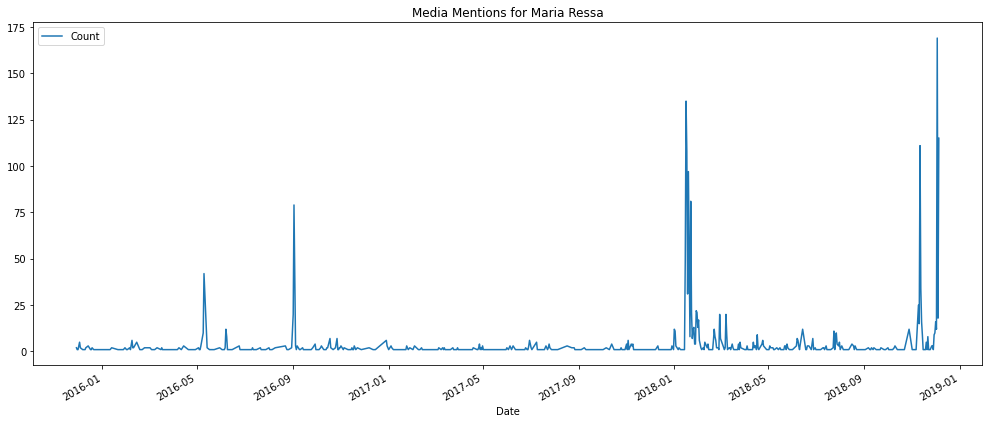

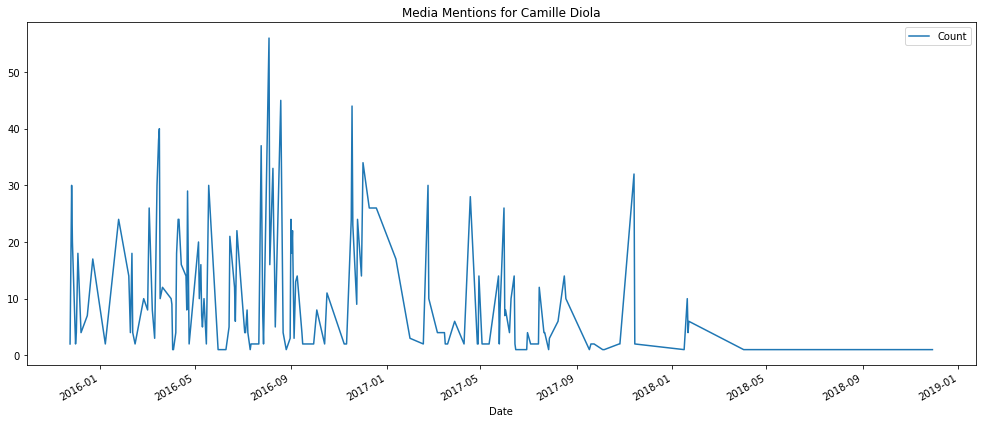

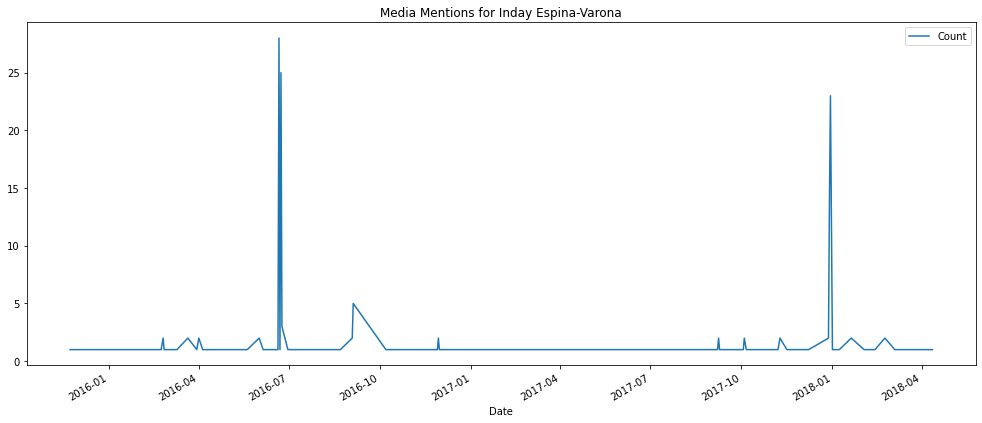

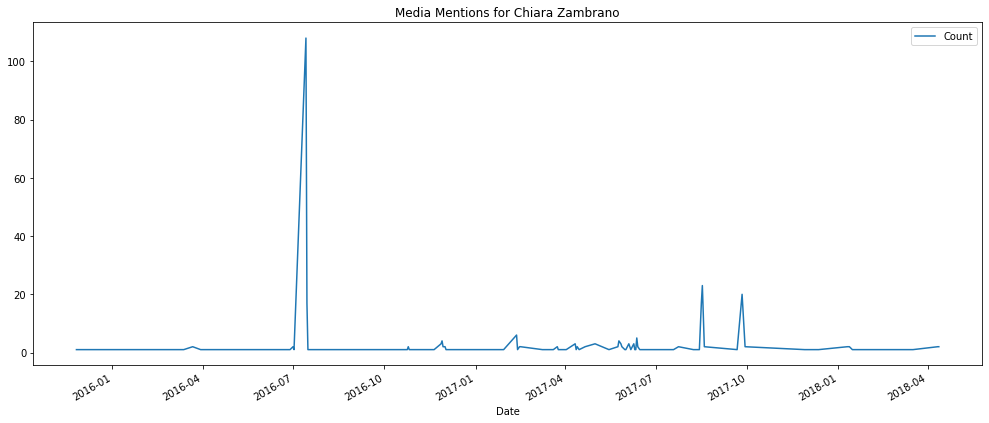

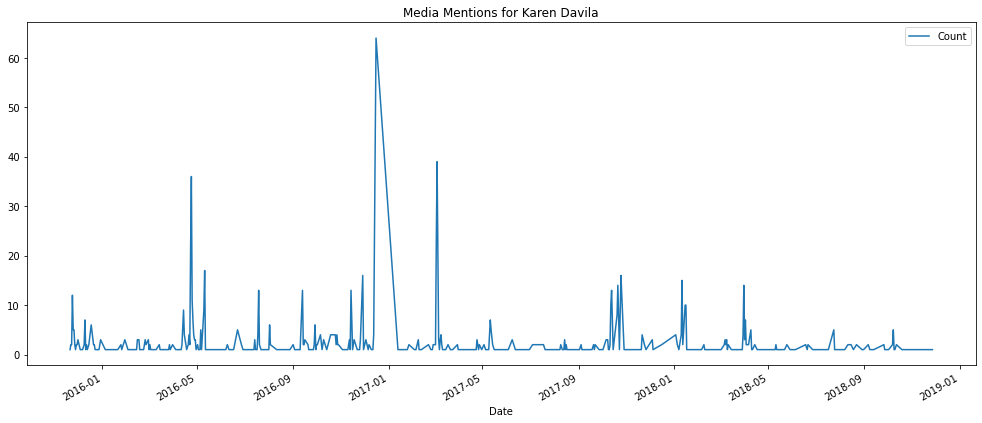

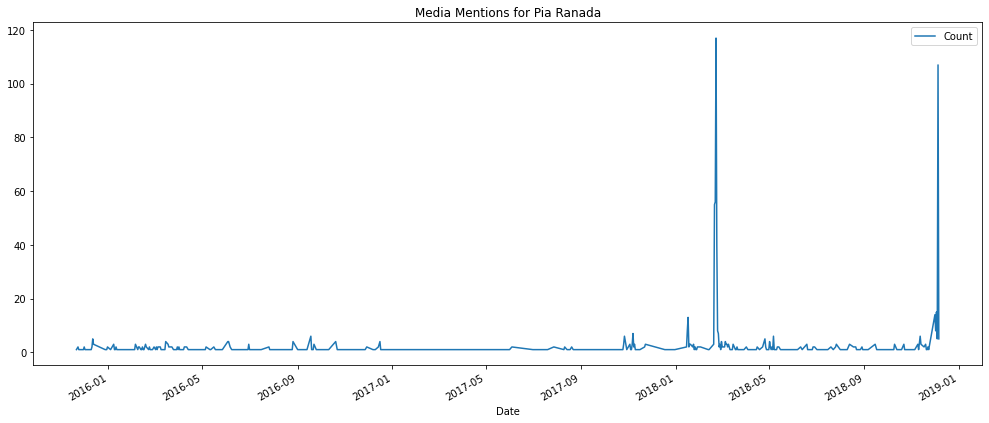

In [12]:
#Graph the media mentions
for name, dict_ in dict_media_mentions.items():
    dict_media_mentions[name].plot(x="Date", y="Count", figsize = (17,7), title = "Media Mentions for " + name)

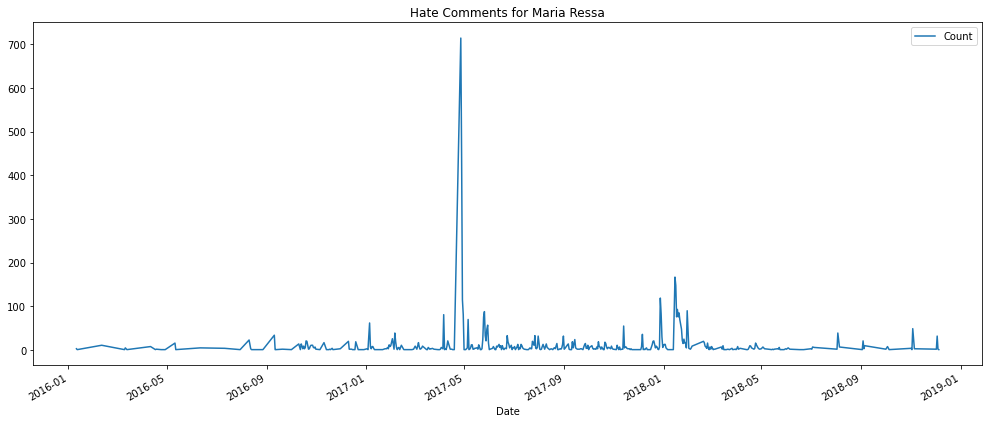

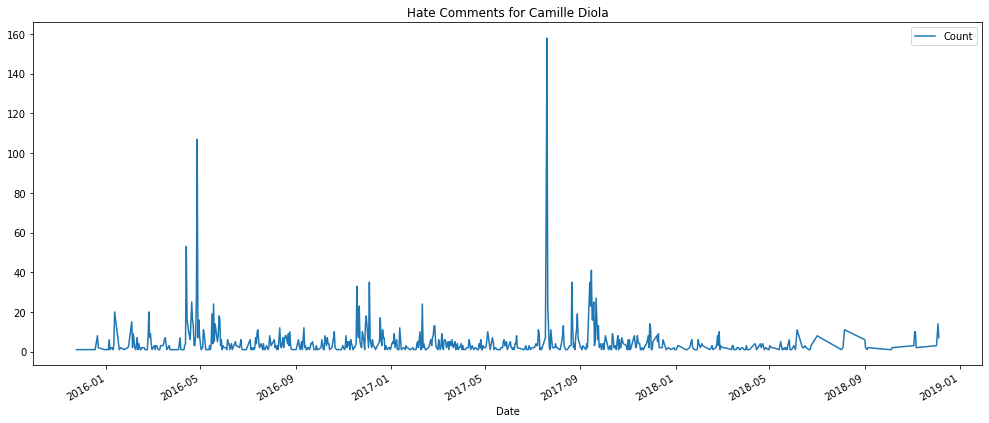

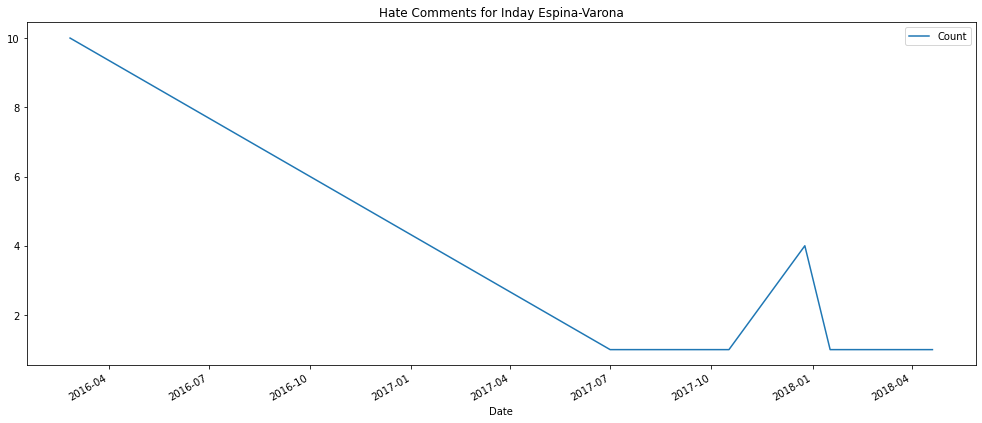

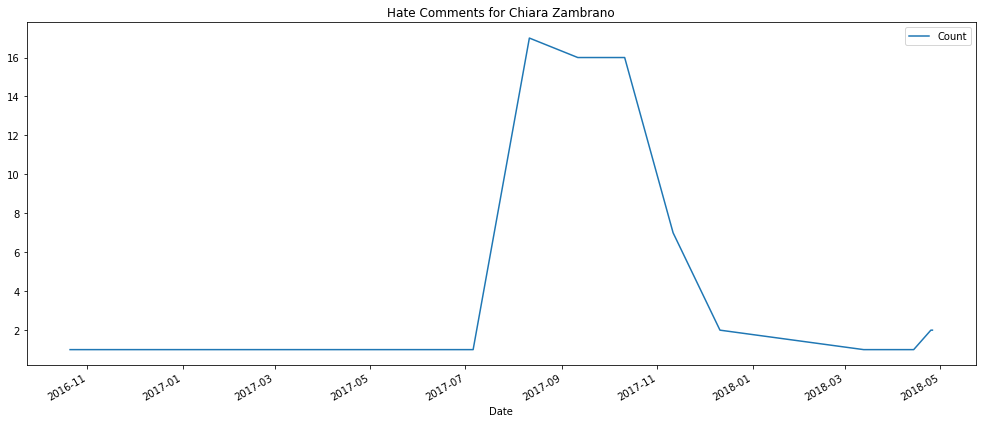

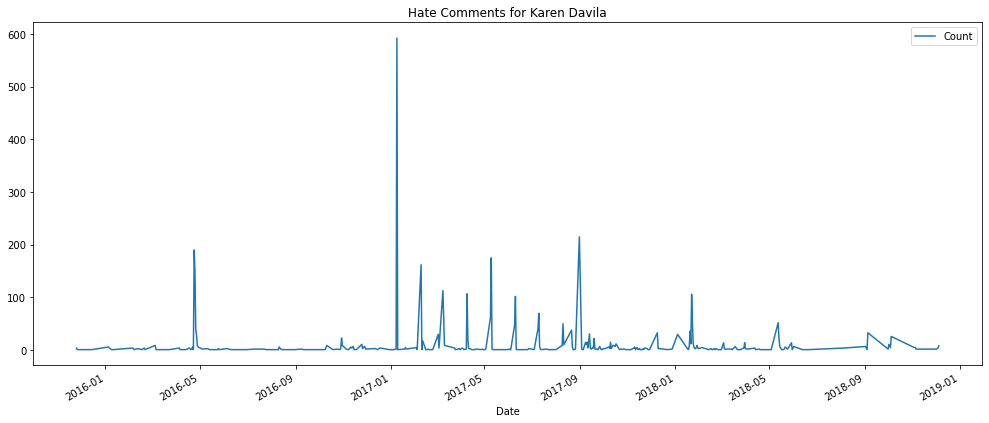

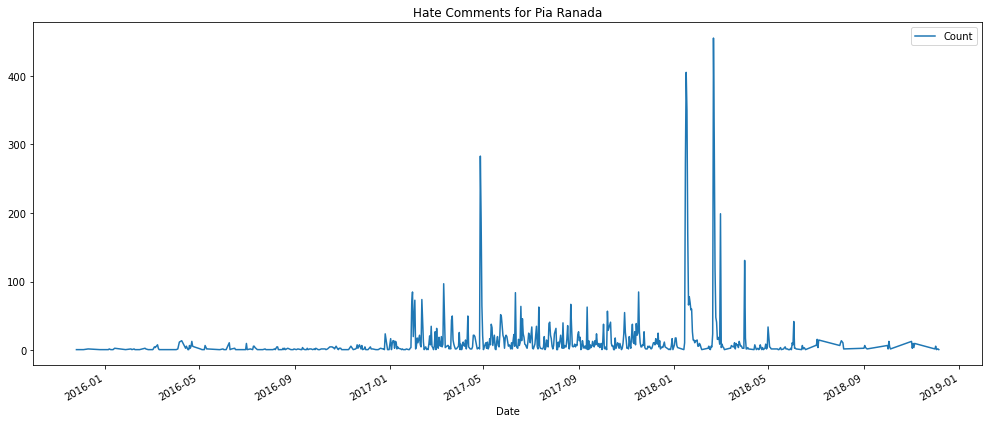

In [13]:
#Graph the hate comments
for name, dict_ in dict_hate_dfs.items():
    dict_.plot(x="Date", y="Count", figsize = (17,7), title = "Hate Comments for " + name)

In [14]:
#Graph the media mentions
for name, dict_ in dict_media_mentions.items():
    #Find the top five days
    print(f"\n{name}\n")
    display(dict_.sort_values(by = "Count", ascending=False).head(12))


Maria Ressa



,Date,Count
7,2018-12-03,169
8,2018-01-16,135
10,2018-12-05,115
11,2018-11-11,111
12,2018-01-17,108
13,2018-01-19,97
14,2018-01-22,81
16,2016-09-02,79
22,2018-01-20,53
24,2018-01-15,49



Camille Diola



,Date,Count
1,2016-08-04,56
4,2016-08-19,45
5,2016-11-18,44
6,2016-03-17,40
7,2016-03-16,38
9,2016-07-25,37
10,2016-12-02,34
13,2016-08-09,33
14,2017-11-13,32
18,2016-05-19,30



Inday Espina-Varona



,Date,Count
1,2016-06-21,28
2,2016-06-23,25
3,2017-12-30,23
6,2017-12-29,14
9,2016-09-04,5
13,2016-06-24,3
21,2016-02-25,2
32,2016-03-21,2
30,2016-06-01,2
28,2018-02-23,2



Chiara Zambrano



,Date,Count
0,2016-07-14,108
1,2017-08-17,23
2,2017-09-26,20
3,2017-08-16,17
4,2016-07-15,17
5,2017-02-11,6
7,2017-06-12,5
8,2016-11-28,4
9,2017-05-25,4
15,2017-04-11,3



Karen Davila



,Date,Count
0,2016-12-16,64
1,2017-03-04,39
2,2016-04-24,36
5,2017-03-03,23
7,2016-04-23,21
8,2016-05-11,17
9,2016-11-29,16
10,2017-10-25,16
11,2018-01-11,15
12,2017-10-21,14



Pia Ranada



,Date,Count
0,2018-02-22,117
1,2018-12-05,107
3,2018-02-21,56
4,2018-02-20,55
5,2018-02-23,40
8,2018-12-03,15
9,2018-12-01,14
10,2018-01-17,13
12,2018-12-02,8
13,2018-01-16,8


In [15]:
dict()

{}

In [16]:
'''
4 types of regressions:
--Single-Peak, Journalist by Journalist
--Single Peak, All Journalist combined
--Multi-Peak, Journo by Journo
--Multi-Peak, Peak by peak
'''
single_peak_regs = {}
multi_peak_regs = {}
peak_by_peak = {}

In [17]:
#Regression Type 1: Single-Peak, Journalist by Journalist.
#Find the highest point of media mentions.
dict_media_peaks = {}
for journo in journo_list:
    name = journo.replace("_", " ")
    first, last = journo.split("_")
    dict_ = dict_media_mentions[name]
    #
    peak = dict_.loc[dict_["Count"].idxmax()].values.tolist()
    dict_media_peaks[name] = peak
#Add regression variables
for journo, df in dict_hate_dfs.items():
    peak_date = dict_media_peaks[journo][0]
    df["Diff From Peak"] = (df["Date"] - peak_date).dt.days
    #df["Time Since Start Date"] = (df["Date"] - start).dt.days
    df.loc[df["Diff From Peak"] > 0, "post"] = 1

In [18]:
dict_hate_dfs["Maria Ressa"].sort_values(by = "Date")

,Date,Count,constant,Journalist,post,Diff From Peak,Time Since Start
34,2016-01-11,3,1,Maria Ressa,0,-1057,51
429,2016-01-12,1,1,Maria Ressa,0,-1056,52
32,2016-02-11,11,1,Maria Ressa,0,-1026,82
278,2016-03-10,1,1,Maria Ressa,0,-998,110
323,2016-03-11,5,1,Maria Ressa,0,-997,111
...,...,...,...,...,...,...,...
221,2018-11-05,3,1,Maria Ressa,0,-28,1080
201,2018-12-02,2,1,Maria Ressa,0,-1,1107
207,2018-12-03,32,1,Maria Ressa,0,0,1108
210,2018-12-04,2,1,Maria Ressa,1,1,1109


In [19]:
#Journalist by Journalist Regressions

for name, df in dict_hate_dfs.items():
    y = df.drop(["Journalist"], axis=1).loc[:, ["Count"]]
    #display(y)
    X = df[df.columns.difference(["Diff From Peak", "Date", "Count", "Journalist"])]
    #display(X)
    X["Post X Time"] = X.loc[:,"post"] * X.loc[:, "Time Since Start"]
    #min_time = X["Time Since Start Date"].min()
    #X.loc[:, "Time Since Start Date"] = X.loc[:, "Time Since Start"] - min_time
    #display(X)
    
    #Perform the Regresssions
    model = sm.OLS(y,X)
    res = model.fit()
    single_peak_regs[name] = res
    print("\nRegression results for " + name + "\n")
    print(res.summary())


Regression results for Maria Ressa

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.04962
Date:                Wed, 31 Aug 2022   Prob (F-statistic):              0.985
Time:                        21:53:19   Log-Likelihood:                -2382.2
No. Observations:                 460   AIC:                             4772.
Df Residuals:                     456   BIC:                             4789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Tim

<ipython-input-19-8cc6b8c3c8ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Post X Time"] = X.loc[:,"post"] * X.loc[:, "Time Since Start"]
<ipython-input-19-8cc6b8c3c8ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Post X Time"] = X.loc[:,"post"] * X.loc[:, "Time Since Start"]
<ipython-input-19-8cc6b8c3c8ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [20]:
#Regression type 2: All Journalists Combined 
all_journo_df = pd.concat(list(dict_hate_dfs.values()))
#all_journo_df.sort_values(by = "Date")
journo_dummies = pd.get_dummies(all_journo_df, columns = ["Journalist"])
y_dum = journo_dummies.loc[:, ["Count"]] 
X_dum = journo_dummies[journo_dummies.columns.difference(["Diff From Peak", "Date", "Count"])]
X_dum["Post X Time"] = X_dum["post"] * X_dum["Time Since Start"]
#Remove a journalist column to avoid collinearity
X_dum = X_dum.drop(columns = ["Journalist_Maria Ressa"])

#Regressions
model = sm.OLS(y_dum, X_dum)
res_dum = model.fit()
print(res_dum.summary())

<ipython-input-20-d3e9e5653b8c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dum["Post X Time"] = X_dum["post"] * X_dum["Time Since Start"]


                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.262
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.51e-09
Time:                        21:53:19   Log-Likelihood:                -10381.
No. Observations:                2105   AIC:                         2.078e+04
Df Residuals:                    2096   BIC:                         2.083e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Journalist_C

#### Multi-Peak Regressions

In [57]:
#Regression Type 3: Multi-peak Regressions

hate_peak_dfs = {}
for journo, df in dict_hate_dfs.items():
    df_peaks = get_closest_peaks(journo, distance = 30, graph=False)
    hate_peak_dfs[journo] = df_peaks

          Date  Count
166 2016-02-08      6
29  2016-05-10     42
16  2016-09-02     79
161 2016-12-29      6
223 2017-04-27      4
            Count
Date             
2018-12-03    169
2018-01-16    135
2018-12-05    115
2018-11-11    111
2018-01-17    108
List of Peak Dates for Maria Ressa:	 [Timestamp('2016-02-08 00:00:00'), Timestamp('2016-05-10 00:00:00'), Timestamp('2016-09-02 00:00:00'), Timestamp('2016-12-29 00:00:00'), Timestamp('2017-04-27 00:00:00'), Timestamp('2017-06-30 00:00:00'), Timestamp('2017-11-03 00:00:00'), Timestamp('2018-01-16 00:00:00'), Timestamp('2018-02-28 00:00:00'), Timestamp('2018-04-17 00:00:00'), Timestamp('2018-06-14 00:00:00'), Timestamp('2018-08-16 00:00:00'), Timestamp('2018-12-03 00:00:00')]
         Date  Count
6  2016-03-17     40
1  2016-08-04     56
10 2016-12-02     34
14 2017-11-13     32
            Count
Date             
2016-08-04     56
2016-08-19     45
2016-11-18     44
2016-03-17     40
2016-03-16     38
List of Peak Dates for Camille 

In [54]:
df_peaks.sort_values(by = "Date")

,Date,Count,constant,Journalist,post,Diff From Peak,Time Since Start,Nearest Peak,After Peak
701,2015-11-26,1,1,Pia Ranada,0,-819,5,2015-12-12,0.0
32,2015-12-05,1,1,Pia Ranada,0,-810,14,2015-12-12,0.0
706,2015-12-11,2,1,Pia Ranada,0,-804,20,2015-12-12,0.0
644,2015-12-26,1,1,Pia Ranada,0,-789,35,2015-12-12,1.0
647,2016-01-02,1,1,Pia Ranada,0,-782,42,2015-12-12,1.0
...,...,...,...,...,...,...,...,...,...
282,2018-12-02,6,1,Pia Ranada,1,283,1107,2018-12-05,0.0
625,2018-12-03,1,1,Pia Ranada,1,284,1108,2018-12-05,0.0
303,2018-12-04,2,1,Pia Ranada,1,285,1109,2018-12-05,0.0
401,2018-12-05,2,1,Pia Ranada,1,286,1110,2018-12-05,0.0


In [48]:
results = {}
for name, hate_dict in hate_peak_dfs.items():
    #Create the design matrix
    df = pd.get_dummies(hate_dict, columns = ["Nearest Peak"])
    #Delete the last peak to avoid multicollinearity
    #display(df.sort_values(by="Date").head())
    df = df.iloc[:,:-1]
    y_dum = df.loc[:,["Count"]]
    X_dum = df[df.columns.difference(["Diff From Peak", "post", "Date", "Count", "Journalist"])]
    X_dum["Post X Time"] = X_dum.loc[:,"After Peak"] * X_dum.loc[:,"Time Since Start"]
    #Readjust starting time
    min_time = X_dum["Time Since Start"].min()
    #X_dum.loc[:,"Time Since First Comment"] = X_dum.loc[:,"Time Since First Comment"] - min_time
    
    #Perform the regression, store the results
    model = sm.OLS(y_dum, X_dum)
    res = model.fit()
    multi_peak_regs[name] = res

<ipython-input-48-2c2d3ce49926>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dum["Post X Time"] = X_dum.loc[:,"After Peak"] * X_dum.loc[:,"Time Since Start"]


In [51]:
multi_peak_params = {}
for name, res in multi_peak_regs.items():
    tvals = res.tvalues[["After Peak", "Time Since Start", "Post X Time"]]
    params = res.params[["After Peak", "Time Since Start", "Post X Time"]]
    df = pd.concat([tvals, params], axis=1)
    multi_peak_params[name] = df
    print(f"\n{name}\n")
    display(res.summary())


Maria Ressa



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.117
Date:                Tue, 30 Aug 2022   Prob (F-statistic):            0.00849
Time:                        20:01:17   Log-Likelihood:                -2366.4
No. Observations:                 460   AIC:                             4765.
Df Residuals:                     444   BIC:                             4831.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                          -1.1269     16.850     -0.067      0.947     -34.242      31.988
Nearest Peak_2016-02-08 00:00:00   160.5386    145.611      1.103      0.271    -125.635     446.712
Nearest Peak_2016-05-10 00:00:00   148.0861    132.155      1.121      0.263    -111.641     407.813
Nearest Peak_2016-09-02 00:00:00   127.3995    113.860      1.119      0.264     -96.372     351.171
Nearest Peak_2016-12-29 00:00:00   109.0481     98.521      1.107      0.269     -84.578     302.674
Nearest Peak_2017-04-27 00:00:00   116.9558     83.501      1.401      0.162     -47.151     281.062
Nearest Peak_2017-06-30 00:00:00    79.7937     72.420      1.102      0.271     -62.535     222.123
Nearest Peak_2017-11-03 00:00:00    60.6512     57.448      1.056      0.292     -52.252     173.555
Nearest Peak_2018-01-16 00:00:00    72.7580     47.273      1.539      0.124     -20.149     165.665
Nearest Peak_2018-02-28 00:00:00    38.4855     41.277      0.932      0.352     -42.637     119.608
Nearest Peak_2018-04-17 00:00:00    29.8802     35.369      0.845      0.399     -39.631      99.392
Nearest Peak_2018-06-14 00:00:00    19.2115     29.566      0.650      0.516     -38.895      77.317
Nearest Peak_2018-08-16 00:00:00    12.9503     23.636      0.548      0.584     -33.502      59.403
Time Since Start                     0.1682      0.138      1.221      0.223      -0.103       0.439
constant                          -170.2760    150.440     -1.132      0.258    -465.939     125.387
Post X Time                         -0.0057      0.021     -0.268      0.789      -0.048       0.036
==============================================================================
Omnibus:                      849.887   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           594735.446
Skew:                          11.818   Prob(JB):                         0.00
Kurtosis:                     177.559   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Camille Diola



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.042
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           3.63e-06
Time:                        20:01:17   Log-Likelihood:                -2390.1
No. Observations:                 658   AIC:                             4794.
Df Residuals:                     651   BIC:                             4826.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                           5.9775      1.571      3.805      0.000       2.893       9.062
Nearest Peak_2016-03-17 00:00:00     5.8128      4.423      1.314      0.189      -2.872      14.498
Nearest Peak_2016-08-04 00:00:00     1.0009      3.484      0.287      0.774      -5.840       7.842
Nearest Peak_2016-12-02 00:00:00     1.0026      2.477      0.405      0.686      -3.862       5.867
Time Since Start                     0.0149      0.008      1.857      0.064      -0.001       0.031
constant                            -2.0912      5.092     -0.411      0.681     -12.090       7.908
Post X Time                         -0.0163      0.004     -4.591      0.000      -0.023      -0.009
==============================================================================
Omnibus:                     1075.833   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           514440.440
Skew:                           9.776   Prob(JB):                         0.00
Kurtosis:                     138.578   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Inday Espina-Varona



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     30.15
Date:                Tue, 30 Aug 2022   Prob (F-statistic):            0.00303
Time:                        20:01:17   Log-Likelihood:                -6.7763
No. Observations:                   9   AIC:                             23.55
Df Residuals:                       4   BIC:                             24.54
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                          10.4228     10.048      1.037      0.358     -17.475      38.320
Nearest Peak_2016-06-21 00:00:00    17.8212      3.411      5.224      0.006       8.349      27.293
Time Since Start                     0.0165      0.006      2.850      0.046       0.000       0.033
constant                            -9.4228      3.883     -2.427      0.072     -20.203       1.357
Post X Time                         -0.0165      0.012     -1.332      0.254      -0.051       0.018
==============================================================================
Omnibus:                        1.443   Durbin-Watson:                   2.396
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                0.153
Skew:                          -0.313   Prob(JB):                        0.926
Kurtosis:                       3.132   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Chiara Zambrano



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     12.04
Date:                Tue, 30 Aug 2022   Prob (F-statistic):            0.00117
Time:                        20:01:17   Log-Likelihood:                -32.349
No. Observations:                  14   AIC:                             74.70
Df Residuals:                       9   BIC:                             77.89
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                         316.3724     73.658      4.295      0.002     149.746     482.999
Nearest Peak_2016-07-14 00:00:00   -31.8194      5.831     -5.457      0.000     -45.011     -18.628
Time Since Start                     0.4444      0.120      3.719      0.005       0.174       0.715
constant                          -262.5556     73.057     -3.594      0.006    -427.821     -97.290
Post X Time                         -0.5055      0.120     -4.209      0.002      -0.777      -0.234
==============================================================================
Omnibus:                        2.984   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                1.029
Skew:                          -0.596   Prob(JB):                        0.598
Kurtosis:                       3.587   Cond. No.                     1.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Karen Davila



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.6909
Date:                Tue, 30 Aug 2022   Prob (F-statistic):              0.760
Time:                        20:01:17   Log-Likelihood:                -1582.5
No. Observations:                 307   AIC:                             3191.
Df Residuals:                     294   BIC:                             3240.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                          11.2176     12.515      0.896      0.371     -13.413      35.848
Nearest Peak_2015-11-24 00:00:00  -119.5356    120.264     -0.994      0.321    -356.222     117.151
Nearest Peak_2016-02-15 00:00:00  -105.1429    109.210     -0.963      0.336    -320.075     109.790
Nearest Peak_2016-04-24 00:00:00   -83.0801     99.926     -0.831      0.406    -279.741     113.581
Nearest Peak_2016-07-19 00:00:00   -89.9207     90.948     -0.989      0.324    -268.913      89.071
Nearest Peak_2016-09-29 00:00:00   -79.3100     82.153     -0.965      0.335    -240.993      82.373
Nearest Peak_2016-12-16 00:00:00   -49.7608     71.670     -0.694      0.488    -190.812      91.291
Nearest Peak_2017-05-11 00:00:00   -41.2123     55.044     -0.749      0.455    -149.543      67.119
Nearest Peak_2017-10-25 00:00:00   -31.6474     36.959     -0.856      0.393    -104.386      41.091
Nearest Peak_2018-03-31 00:00:00   -15.9822     20.294     -0.788      0.432     -55.922      23.957
Time Since Start                    -0.1061      0.122     -0.866      0.387      -0.347       0.135
constant                           111.5764    116.726      0.956      0.340    -118.149     341.302
Post X Time                         -0.0057      0.021     -0.266      0.790      -0.048       0.036
==============================================================================
Omnibus:                      514.911   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           157001.025
Skew:                           9.136   Prob(JB):                         0.00
Kurtosis:                     112.269   Cond. No.                     7.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Pia Ranada



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.722
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           1.27e-12
Time:                        20:01:17   Log-Likelihood:                -3278.2
No. Observations:                 657   AIC:                             6580.
Df Residuals:                     645   BIC:                             6634.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
After Peak                           6.2462      8.430      0.741      0.459     -10.308      22.801
Nearest Peak_2015-12-12 00:00:00    66.2207     45.985      1.440      0.150     -24.077     156.519
Nearest Peak_2016-03-15 00:00:00    63.8954     40.901      1.562      0.119     -16.419     144.210
Nearest Peak_2016-09-18 00:00:00    54.3713     34.613      1.571      0.117     -13.596     122.338
Nearest Peak_2016-12-16 00:00:00    59.0675     29.456      2.005      0.045       1.227     116.908
Nearest Peak_2017-11-07 00:00:00    40.8229     20.703      1.972      0.049       0.169      81.476
Nearest Peak_2018-02-22 00:00:00    66.6304     16.750      3.978      0.000      33.739      99.521
Nearest Peak_2018-05-07 00:00:00    24.9752     14.914      1.675      0.095      -4.311      54.262
Nearest Peak_2018-09-15 00:00:00    12.5135     14.826      0.844      0.399     -16.599      41.626
Time Since Start                     0.0720      0.039      1.830      0.068      -0.005       0.149
constant                           -71.5529     44.106     -1.622      0.105    -158.162      15.056
Post X Time                         -0.0288      0.012     -2.412      0.016      -0.052      -0.005
==============================================================================
Omnibus:                      841.340   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93907.947
Skew:                           6.567   Prob(JB):                         0.00
Kurtosis:                      60.078   Cond. No.                     4.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
for name, df in multi_peak_params.items():
    print(name)
    display(df)

Maria Ressa


,0,1
After Peak,-0.066878,-1.126865
Time Since Start,1.220864,0.168227
Post X Time,-0.268187,-0.005716


Camille Diola


,0,1
After Peak,3.805002,5.977481
Time Since Start,1.856558,0.014935
Post X Time,-4.591293,-0.016279


Inday Espina-Varona


,0,1
After Peak,1.037308,10.422801
Time Since Start,2.850257,0.016511
Post X Time,-1.331976,-0.016511


Chiara Zambrano


,0,1
After Peak,4.295137,316.372411
Time Since Start,3.718667,0.444444
Post X Time,-4.209392,-0.505484


Karen Davila


,0,1
After Peak,0.896328,11.217648
Time Since Start,-0.866140,-0.106064
Post X Time,-0.266477,-0.005669


Pia Ranada


,0,1
After Peak,0.740915,6.246248
Time Since Start,1.829505,0.071987
Post X Time,-2.412291,-0.028764


##### Multi-peak Version 2: Normalizing the data to find valid peaks

In [21]:
#The goal is to normalize the count data to find some empirical rule for identifying peaks
#There's min-max scaling and standardization:
test = dict_media_mentions["Camille Diola"].loc[:, ["Count", "Date"]].set_index("Date")
#display(test)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
test_minmax = test.copy()
test_minmax["Count Scaled"] = scaler.fit_transform(test[["Count"]])
#display(test)
display(test_minmax)

,Count,Count Scaled
Date,,
2016-08-04,56,1.000000
2016-08-19,45,0.800000
2016-11-18,44,0.781818
2016-03-17,40,0.709091
2016-03-16,38,0.672727
...,...,...
2016-06-06,1,0.000000
2016-06-03,1,0.000000
2016-05-31,1,0.000000


<AxesSubplot:xlabel='Date'>

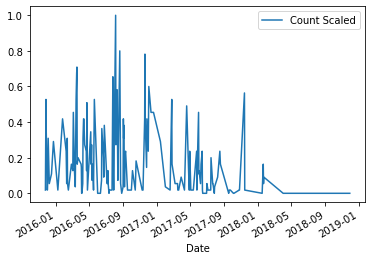

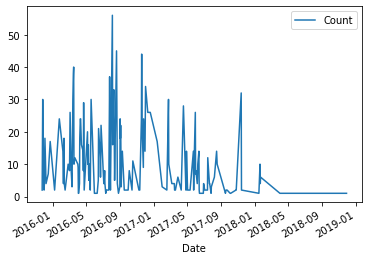

In [22]:
test_minmax.plot(y = "Count Scaled")
test.plot()

<AxesSubplot:xlabel='Date'>

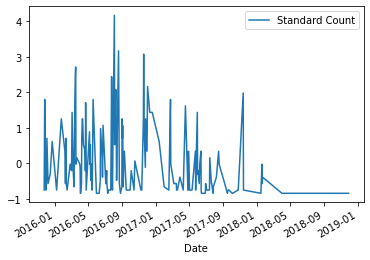

In [23]:
#Standardization test: z-score
test_std = test.copy()
test_std["Standard Count"] = (test_std["Count"] - test_std["Count"].mean())/test_std["Count"].std()
test_std.plot(y = "Standard Count")

In [24]:
dict_hate_dfs["Maria Ressa"].loc[:, "Count"]

0       3
1       1
2      20
3      17
4      16
       ..
458     3
459     1
460     1
461     1
462     7
Name: Count, Length: 460, dtype: int64

<AxesSubplot:xlabel='Date'>

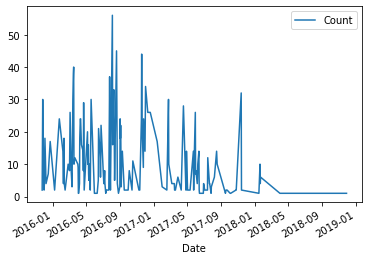

In [25]:
dict_media_mentions["Camille Diola"].plot(x="Date", y="Count")

In [26]:
test_minmax["SMA10"] = test_minmax["Count"].rolling(10).mean()
test_minmax["SMA30"] = test_minmax["Count"].rolling(30).mean()
test_minmax["SMA60"] = test_minmax["Count"].rolling(60).mean()

In [27]:
test_minmax

,Count,Count Scaled,SMA10,SMA30,SMA60
Date,,,,,
2016-08-04,56,1.000000,NaN,NaN,NaN
2016-08-19,45,0.800000,NaN,NaN,NaN
2016-11-18,44,0.781818,NaN,NaN,NaN
2016-03-17,40,0.709091,NaN,NaN,NaN
2016-03-16,38,0.672727,NaN,NaN,NaN
...,...,...,...,...,...
2016-06-06,1,0.000000,1.0,1.433333,1.800000
2016-06-03,1,0.000000,1.0,1.400000,1.766667
2016-05-31,1,0.000000,1.0,1.366667,1.733333


<AxesSubplot:xlabel='Date'>

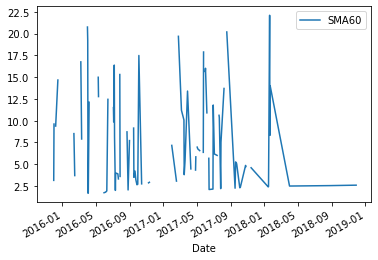

In [28]:
test_minmax.plot(y="SMA60")

<AxesSubplot:xlabel='Date'>

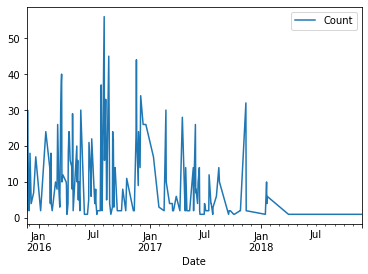

In [29]:
#Computing a rolling average won't work given the sizeable time gaps in each dataset.
test_resamp = test.resample("1D").mean().interpolate()
test_resamp.plot()

<AxesSubplot:xlabel='Date'>

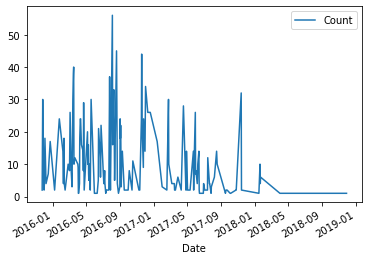

In [30]:
test.plot()

In [31]:
test.sort_values(by="Date")

,Count
Date,
2015-11-24,2
2015-11-26,30
2015-11-27,20
2015-12-01,2
2015-12-02,4
...,...
2018-01-21,4
2018-01-22,6
2018-04-02,1


In [32]:
test_resamp.sort_values(by="Date")

,Count
Date,
2015-11-24,2.0
2015-11-25,16.0
2015-11-26,30.0
2015-11-27,20.0
2015-11-28,15.5
...,...
2018-11-25,1.0
2018-11-26,1.0
2018-11-27,1.0


In [33]:
test_resamp["SMA10"] = test_resamp["Count"].rolling(10).mean()
test_resamp["SMA30"] = test_resamp["Count"].rolling(30).mean()
test_resamp["SMA60"] = test_resamp["Count"].rolling(60).mean()

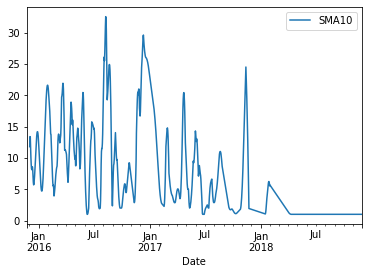

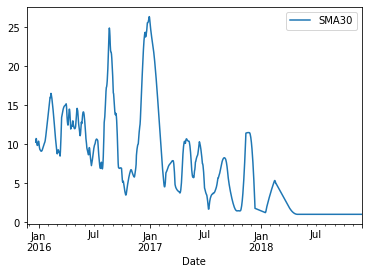

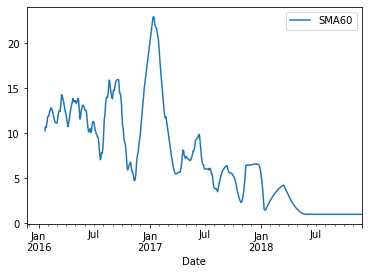

In [34]:
for val in ["SMA10", "SMA30", "SMA60"]:
    test_resamp.plot(y=val)

In [35]:
#test_minmax["Count Scaled"] = scaler.fit_transform(test[["Count"]])
test_minmax = test_resamp.copy()
test_minmax["Count Scaled"] = scaler.fit_transform(test_resamp[["Count"]])
for val in ["SMA10", "SMA30", "SMA60"]:
    num = int(val[-2:])
    test_minmax[val + " Scaled"] = test_minmax["Count Scaled"].rolling(num).mean()

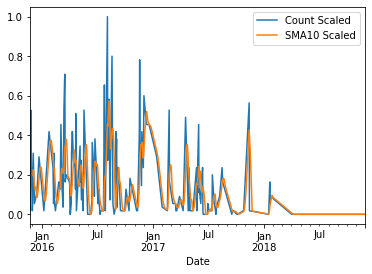

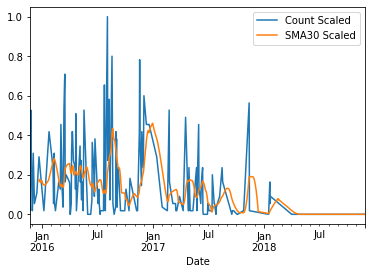

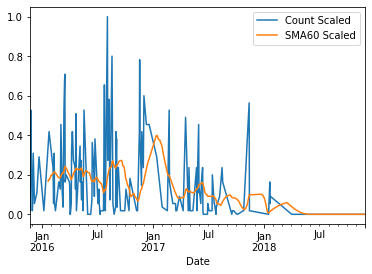

In [36]:
#test_minmax["Count Scaled"] = scaler.fit_transform(test_resamp[["Count"]])
for val in ["SMA10", "SMA30", "SMA60"]:
    label = val + " Scaled"
    test_minmax.plot(y=["Count Scaled" ,label])

In [37]:
#test_minmax["Count Scaled"] = scaler.fit_transform(test[["Count"]])
test_minmax_no_samp = test.copy()
test_minmax_no_samp["Count Scaled"] = scaler.fit_transform(test[["Count"]])

<AxesSubplot:xlabel='Date'>

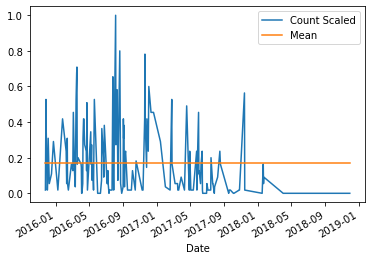

In [38]:
test_minmax_no_samp["Mean"] = test_minmax_no_samp["Count Scaled"].mean()
test_minmax_no_samp.plot(y = ["Count Scaled", "Mean"])

<AxesSubplot:xlabel='Date'>

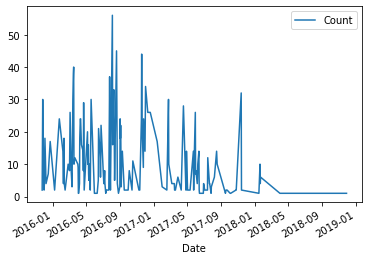

In [39]:
test.plot()

In [40]:
test_minmax

,Count,SMA10,SMA30,SMA60,Count Scaled,SMA10 Scaled,SMA30 Scaled,SMA60 Scaled
Date,,,,,,,,
2015-11-24,2.0,NaN,NaN,NaN,0.018182,NaN,NaN,NaN
2015-11-25,16.0,NaN,NaN,NaN,0.272727,NaN,NaN,NaN
2015-11-26,30.0,NaN,NaN,NaN,0.527273,NaN,NaN,NaN
2015-11-27,20.0,NaN,NaN,NaN,0.345455,NaN,NaN,NaN
2015-11-28,15.5,NaN,NaN,NaN,0.263636,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2018-11-25,1.0,1.0,1.0,1.0,0.000000,0.0,4.395789e-16,0.0
2018-11-26,1.0,1.0,1.0,1.0,0.000000,0.0,4.395789e-16,0.0
2018-11-27,1.0,1.0,1.0,1.0,0.000000,0.0,4.395789e-16,0.0


In [41]:
int("oiewf10"[-2:])

10

In [45]:
from scipy.signal import savgol_filter
count = test["Count"]
yhat = savgol_filter(count, 31, 5)

165